### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [43]:
%matplotlib inline

import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
from scipy.stats import pearsonr, normaltest
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning) 
import os 

os.chdir("/Users/gabrielanthonysanchez/Desktop")

#### Step 2: Examine your data 

In [3]:
df_raw = pd.read_csv("/Users/gabrielanthonysanchez/Desktop/Data Science/DSI-projects/Python Tutorials/airport_operations.csv")
OpsDF = df_raw.dropna() 
print OpsDF.head()

  airport  year  departures for metric computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   
2     ABQ  2006                              49682   
3     ABQ  2007                              53255   
4     ABQ  2008                              49589   

   arrivals for metric computation  percent on-time gate departures  \
0                            53818                           0.8030   
1                            51877                           0.8140   
2                            51199                           0.7983   
3                            53611                           0.8005   
4                            49512                           0.8103   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   
2                              0

In [4]:
df_raw = pd.read_csv("/Users/gabrielanthonysanchez/Desktop/Data Science/DSI-projects/Python Tutorials/airport_cancellations.csv")
cancelDF = df_raw.dropna() 
print cancelDF.head()

  Airport    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   Departure Diversions  Arrival Diversions  
0                  71.0                46.0  
1                  61.0                33.0  
2                  71.0               124.0  
3                 107.0                45.0  
4                  79.0                42.0  


### Intro: Write a problem statement / aim for this project

We want to understand the behavior of flight cancellations
Answer: 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [5]:
%load_ext sql

In [6]:
%%sql
postgresql://gabrielanthonysanchez@localhost:5432

u'Connected: gabrielanthonysanchez@None'

In [7]:
from sqlalchemy import create_engine

engine = create_engine('postgresql://gabrielanthonysanchez@localhost:5432')
conn = engine.connect()
conn.execute("commit")
conn.execute("create database airports")
conn.close()

ProgrammingError: (psycopg2.ProgrammingError) database "airports" already exists
 [SQL: 'create database airports']

Load our csv files into tables

In [8]:
%sql postgresql://gabrielanthonysanchez@localhost:5432/airports


u'Connected: gabrielanthonysanchez@airports'

In [9]:
%%sql
CREATE TABLE operations(
    Airport varchar(80), 
    Year date, 
    average_gate_departure_delay FLOAT
);

(psycopg2.ProgrammingError) relation "operations" already exists
 [SQL: 'CREATE TABLE operations(\n    Airport varchar(80), \n    Year date, \n    average_gate_departure_delay FLOAT\n);']


In [10]:
%%sql
ALTER TABLE operations ADD COLUMN average_airport_departure_delay float;
ALTER TABLE operations ADD COLUMN average_gate_arrival_delay float;

(psycopg2.ProgrammingError) column "average_airport_departure_delay" of relation "operations" already exists
 [SQL: 'ALTER TABLE operations ADD COLUMN average_airport_departure_delay float;']


In [11]:
%%sql
CREATE TABLE cancellations(
    Airport varchar(80), 
    Year date, 
    Departure_Cancellations float, 
    Arrival_Cancellations float
);

(psycopg2.ProgrammingError) relation "cancellations" already exists
 [SQL: 'CREATE TABLE cancellations(\n    Airport varchar(80), \n    Year date, \n    Departure_Cancellations float, \n    Arrival_Cancellations float\n);']


In [12]:
%%sql
select * from operations

0 rows affected.


airport,year,average_gate_departure_delay,average_airport_departure_delay,average_gate_arrival_delay


In [16]:
%%sql 
COPY operations(
    airport, year, average_gate_departure_delay, 
    average_airport_departure_delay, average_gate_arrival_delay) 
FROM '/Users/gabrielanthonysanchez/Desktop/Data Science/DSI-projects/Python Tutorials/Airport_operations.csv' 
WITH (FORMAT CSV);

DataError: (psycopg2.DataError) extra data after last expected column
CONTEXT:  COPY operations, line 1: "airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate ..."
 [SQL: "COPY operations(\n    airport, year, average_gate_departure_delay, \n    average_airport_departure_delay, average_gate_arrival_delay) \nFROM '/Users/gabrielanthonysanchez/Desktop/Data Science/DSI-projects/Python Tutorials/Airport_operations.csv' \nWITH (FORMAT CSV);"]

Join airport_cancellations.csv and airport operations.csv into one table

In [17]:
OpsDF.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [18]:
cancelDF.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [27]:
airport_info = pd.concat([cancelDF, OpsDF], axis=)

In [28]:
airport_info.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,year,departures for metric computation,arrivals for metric computation,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ABQ,2004,53971,53818,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,ABQ,2005,51829,51877,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,ABQ,2006,49682,51199,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,ABQ,2007,53255,53611,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,ABQ,2008,49589,49512,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [32]:
del airport_info['year']


KeyError: 'year'

In [30]:
airport_info.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,airport,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,ABQ,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,ABQ,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,ABQ,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,ABQ,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,ABQ,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [33]:
del airport_info['airport']

In [34]:
airport_info.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


Query the database for our intial data

In [ ]:
cur = conn.cursor()
cur.execute("""SELECT * FROM mydb""")
ap = cur.fetchall()
print ap

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [39]:
airport_info.describe()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,805.000000,805.000000,805.000000,805.000000,805.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665,108257.063020,107815.561237,0.764119,0.714283,0.754281,13.561403,13.703389,3.519750,16.249964,2.921237,1.348894,3.330773,14.013222
std,3.158116,1835.961943,1975.224868,172.345539,228.521615,98278.401526,97916.908601,0.093361,0.101271,0.082302,4.746563,3.792181,2.391278,5.353012,1.201453,0.882252,1.026872,4.482215
min,2004.000000,0.000000,0.000000,0.000000,0.000000,261.000000,259.000000,0.246700,0.245700,0.324100,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,37653.000000,37502.000000,0.745700,0.684800,0.737500,10.910000,11.260000,2.210000,12.950000,2.050000,0.800000,2.630000,11.300000
50%,2009.000000,663.000000,642.000000,110.000000,84.000000,72043.000000,71254.000000,0.782500,0.737200,0.768300,12.640000,12.810000,2.990000,15.220000,2.650000,1.080000,3.160000,13.080000
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000,162913.000000,160775.000000,0.809800,0.772200,0.796500,14.950000,15.650000,4.080000,17.940000,3.620000,1.740000,3.860000,15.250000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.880000


In [69]:
airport_info.fillna(0) 

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2009.0,192.0,162.0,74.0,26.0,42550,42704,0.8341,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,ABQ,2010.0,222.0,177.0,71.0,50.0,42302,42169,0.8144,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,ABQ,2011.0,345.0,294.0,77.0,61.0,42283,42297,0.8072,0.7758,0.8022,10.81,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,0.7554,12.56,10.77,2.64,14.28,1.60,0.92,2.35,12.76


In [71]:
import seaborn as sns

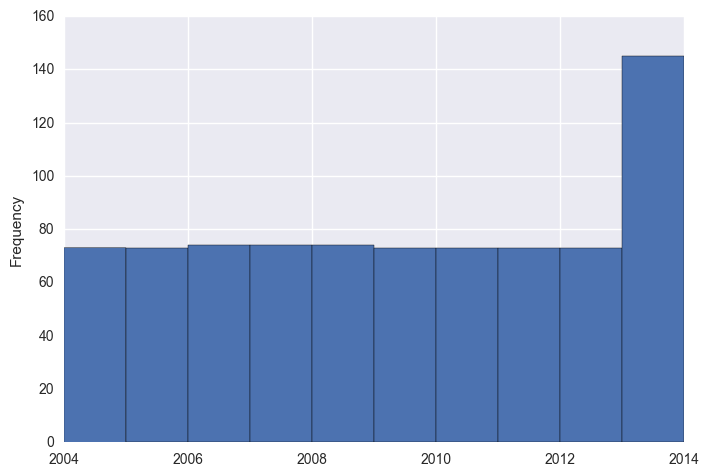

In [78]:
airport_info['Year'].plot(kind='hist')

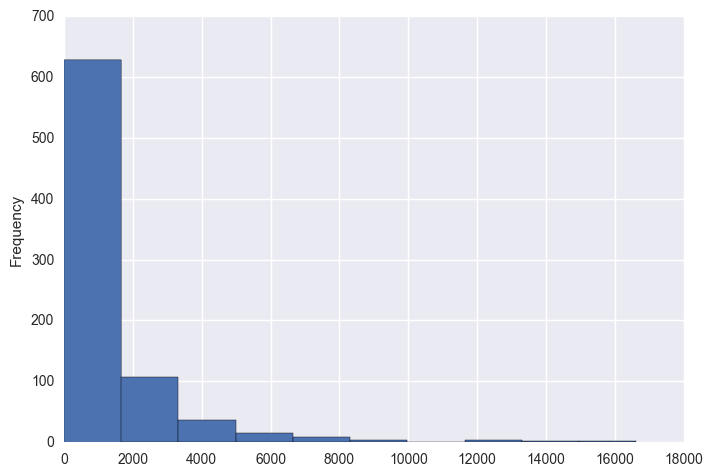

In [79]:
airport_info['Departure Cancellations'].plot(kind='hist')

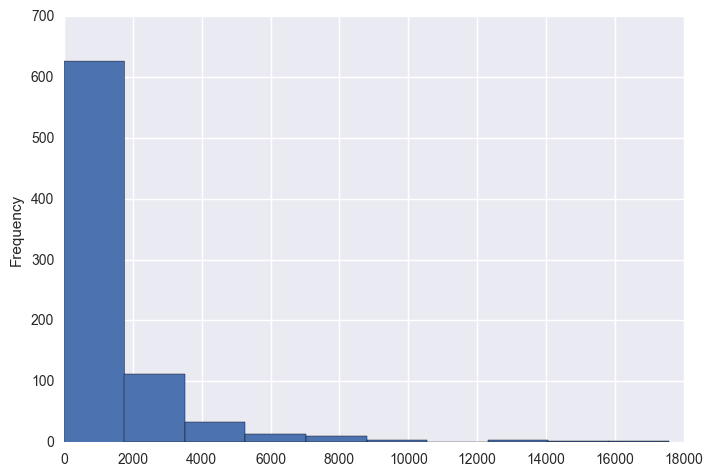

In [80]:
airport_info['Arrival Cancellations'].plot(kind='hist')

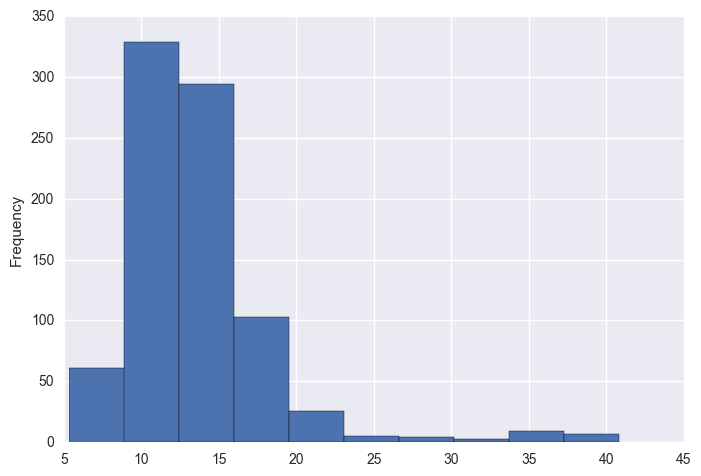

In [81]:
airport_info['average_gate_departure_delay'].plot(kind='hist')

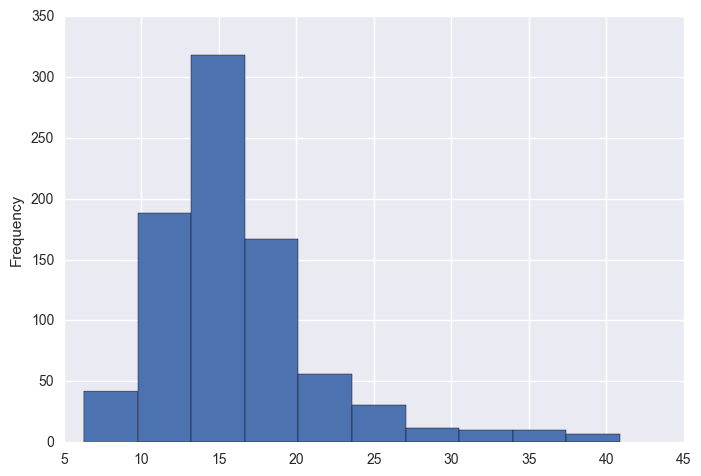

In [82]:
airport_info['average airport departure delay'].plot(kind='hist')

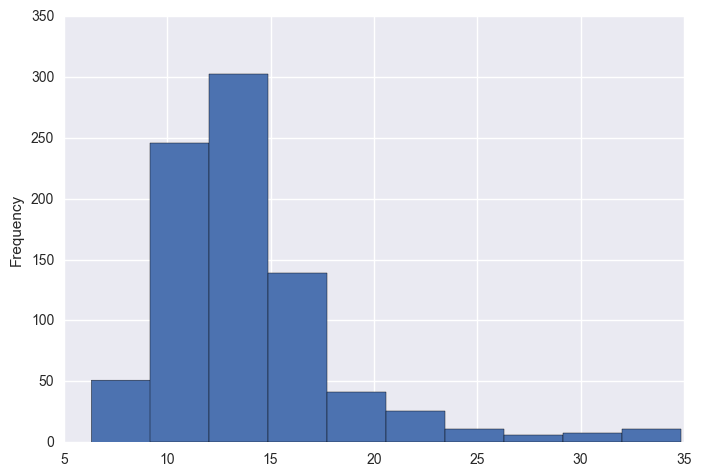

In [83]:
airport_info['average gate arrival delay'].plot(kind='hist')

#### Are there any unique values? 

In [85]:
airport_info.Airport.unique()

array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN',
       'DFW', 'DTW', 'EWR', 'FLL', 'HNL', 'HOU', 'HPN', 'IAD', 'IAH',
       'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB', 'MCI',
       'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK',
       'OGG', 'OMA', 'ONT', 'ORD', 'OXR', 'PBI', 'PDX', 'PHL', 'PHX',
       'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW', 'SAN', 'SAT', 'SDF',
       'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'SWF',
       'TPA', 'TUS', nan], dtype=object)

In [86]:
airport_info.Year.unique()

array([ 2004.,  2005.,  2006.,  2007.,  2008.,  2009.,  2010.,  2011.,
        2012.,  2013.,  2014.,    nan])

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [93]:
encodeAir = preprocessing.LabelEncoder()
airport_info.Airport = encodeAir.fit_transform(airport_info.Airport)

In [94]:
airport_info.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,1,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,1,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,1,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,1,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,1,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [95]:
airport_info.Airport.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74,  0])

#### 3.2 Format and Clean the Data

In [99]:
taxi = airport_info['average_taxi_out_time']
gate = airport_info['average_gate_departure_delay']
year = airport_info['Year']
taxDel = airport_info['average taxi out delay']
airDel = airport_info['average airborne delay']
DepCan = airport_info['Departure Cancellations']

In [100]:
del airport_info['departures for metric computation']
del airport_info['arrivals for metric computation']

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [106]:
normaltest(airport)

NormaltestResult(statistic=array([ 561.18915806,  652.90768981,  684.12784677,  679.5944024 ,
        340.66598773,  546.4736383 ,  577.53660583,  295.17635646,
        458.57576139,  496.02504111,  289.30494498,  432.03200401,
        283.67638196,  127.70305447,  225.93378643,  112.80578789,
        296.78839796]), pvalue=array([  1.37823310e-122,   1.67069265e-142,   2.77667862e-149,
         2.67886330e-148,   1.06003616e-074,   2.16150971e-119,
         3.88614942e-126,   8.00329087e-065,   2.63960320e-100,
         1.94773953e-108,   1.50740310e-063,   1.53264766e-094,
         2.51452717e-062,   1.86051879e-028,   8.69163819e-050,
         3.19546744e-025,   3.57452416e-065]))

In [105]:
airport= airport_info.dropna()

In [107]:
airport_normalized = preprocessing.normalize(airport, norm='l2')

#### 4.2 Find correlations in the data

In [109]:
# truncate arrays to same length
taxi1 = taxi[0:806]
gate1 = gate[0:806]
year1 = year[0:806]
taxDel1 = taxDel[0:806]
airDel1 = taxDel[0:806]

In [110]:
pearsonr(taxi1, airDel1)

(0.91801865809306404, 0.0)

In [111]:
pearsonr(gate1, airDel1)

(0.099734112232175001, 0.0045949201809180997)

In [112]:
pearsonr(year1, airDel1)

(nan, 1.0)

In [113]:
pearsonr(taxDel1, airDel1)

(1.0, 0.0)

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [115]:
x = airport.ix[:,1:].values
y = airport.ix[:,0].values

In [116]:
xStand = preprocessing.StandardScaler().fit_transform(x)

In [117]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [118]:
print eigenValues

[  6.60384154e+00   3.94403867e+00   2.25266786e+00   1.07914651e+00
   5.63427643e-01   4.61536080e-01   3.39494625e-01   2.85150942e-01
   1.69717248e-01   1.32433497e-01   1.00050133e-01   6.86706166e-02
   1.35848489e-02   3.56135165e-03   1.75627366e-03   8.22661943e-04]


In [119]:
print eigenVectors

[[  1.75334897e-02  -4.80822786e-02  -1.15069827e-01   9.06557892e-01
    1.29212386e-01   3.63648269e-01   5.67110527e-02   6.70525621e-02
   -2.47162478e-02  -7.60444990e-03   6.62599070e-02   8.70544416e-03
    1.45101635e-02   1.71818033e-02   1.34981947e-03   1.35615211e-03]
 [ -1.06581253e-01   4.07786456e-01  -2.83582608e-01  -8.41325453e-02
    1.14303276e-01   1.10184204e-01  -2.66145212e-01   3.88422207e-01
   -4.13142950e-02   3.07571952e-02  -4.31595203e-02   3.18551043e-02
    3.39803915e-02   9.55656840e-02  -6.83862861e-01  -6.67542659e-02]
 [ -1.07194825e-01   4.09888453e-01  -2.85009628e-01  -8.05425767e-02
    1.28645259e-01   1.06044630e-01  -2.44007340e-01   3.59369901e-01
    8.89660058e-03  -2.57931477e-02  -3.73795938e-02   1.22013599e-02
   -4.27749921e-02  -9.70829269e-02   7.05606870e-01   6.98238023e-02]
 [ -1.12138338e-01   4.04991741e-01  -2.24243371e-01   1.93513458e-02
    4.02714142e-02   2.24814570e-02   1.49281119e-01  -5.32542922e-01
    4.37025527e-0

In [120]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

6.60384153576
3.94403867224
2.25266785973
1.07914651087
0.563427642622
0.461536080053
0.339494624612
0.285150942038
0.169717247738
0.132433496534
0.100050132544
0.0686706166072
0.0135848489148
0.00356135164611
0.00175627365676
0.000822661943453


In [121]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [124]:
print varExpl

[41.222737536911986, 24.619620283242547, 14.061684466005437, 6.7362872262424922, 3.5170483281654072, 2.8810171456750298, 2.119205575995478, 1.7799794829060387, 1.0594151178670963, 0.82668114295766826, 0.62453654165734007, 0.42865819683386219, 0.084799833287742502, 0.022230797542470003, 0.010963074689722923, 0.0051352500196881461]


In [123]:
cvarex = np.cumsum(varExpl)

In [125]:
print cvarex

[  41.22273754   65.84235782   79.90404229   86.64032951   90.15737784
   93.03839499   95.15760056   96.93758005   97.99699516   98.82367631
   99.44821285   99.87687104   99.96167088   99.98390168   99.99486475
  100.        ]


In [126]:
PCA_A = PCA(n_components=3)
Y = PCA_A.fit_transform(xStand)

In [127]:
print Y

[[ -2.29080888  -0.74100238  -0.13059605]
 [ -2.7337451   -0.66676686  -0.15080761]
 [ -2.05750953  -0.74670685   0.27393781]
 ..., 
 [ 11.22109955  -7.56882709   4.83028413]
 [ 10.75499723  -7.35331838   4.69074405]
 [  9.79115614  -6.9181929    4.35641338]]


In [128]:
Ydf = pd.DataFrame(Y, columns=["PC1", "PC2", "PCA3"])

In [131]:
airports2 = airport[['Airport', 'Year']]

In [132]:
airport_pca = airports2.join(Ydf, on=None, how='left')

In [133]:
airport_pca.head()

,Airport,Year,PC1,PC2,PCA3
0,1,2004.0,-2.290809,-0.741002,-0.130596
1,1,2005.0,-2.733745,-0.666767,-0.150808
2,1,2006.0,-2.057510,-0.746707,0.273938
3,1,2007.0,-1.608340,-0.740912,0.000806
4,1,2008.0,-2.223545,-0.705502,0.044347


In [137]:
airport_pca[0:15]

,Airport,Year,PC1,PC2,PCA3
0,1,2004.0,-2.290809,-0.741002,-0.130596
1,1,2005.0,-2.733745,-0.666767,-0.150808
2,1,2006.0,-2.057510,-0.746707,0.273938
3,1,2007.0,-1.608340,-0.740912,0.000806
4,1,2008.0,-2.223545,-0.705502,0.044347
5,1,2009.0,-3.432371,-0.512294,0.047879
6,1,2010.0,-2.931957,-0.698147,0.300338
7,1,2011.0,-2.627240,-0.695085,0.384261
8,1,2012.0,-3.052025,-0.598514,0.298548
9,1,2013.0,-1.529374,-1.276313,0.632933


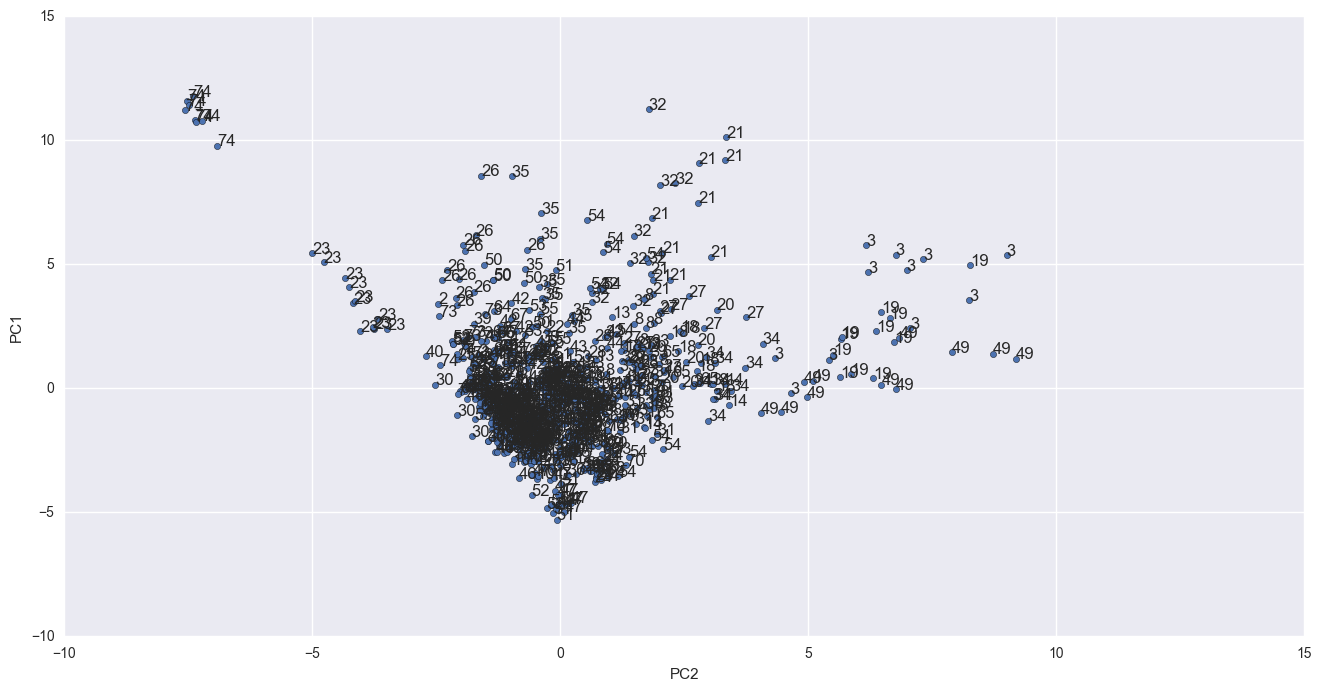

In [135]:
graph = airport_pca.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, airport in enumerate(airport['Airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

#### 5.2 Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied